# Install, Paths and Parameters

In [1]:
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchattacks
from torchattacks import *
from tqdm import tqdm
import random
import sys

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
# from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.data import *
from src.model.train import *

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')
MAX_PATH = Path('/','cluster', 'scratch', 'mmathys', 'dl_data')

LOG_BASE_PATH = Path(MAX_PATH, 'logs')

# DamageNet
DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')

# Image Net
ORI_PATH = Path(DATA_PATH, 'ori_data')
CLASS_SUBSET_PATH = Path(ORI_PATH, 'class_subset.npy')

VAL_PATH = Path(ORI_PATH, 'validation')
VAL_IMAGES_PATH = Path(VAL_PATH,'images')
VAL_LABEL_PATH = Path(VAL_PATH, 'correct_labels.txt')

TRAIN_PATH = Path(ORI_PATH, 'train')
TRAIN_IMAGES_PATH = Path(TRAIN_PATH,'images')
TRAIN_LABEL_PATH = Path(TRAIN_PATH, 'correct_labels.txt')

In [2]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
# INDEX_SUBSET = get_random_indexes(number_of_images = 50000, n_samples=1000)
# CLASS_SUBSET = get_random_classes(number_of_classes = 10, min_rand_class = 1, max_rand_class = 1001)


CLASS_SUBSET = np.load(CLASS_SUBSET_PATH)

NUM_WORKERS= 0
PIN_MEMORY=True

BATCH_SIZE = 16

DEVICE = 'cuda'

In [3]:
CLASS_SUBSET = CLASS_SUBSET[:3]

# Load data

In [4]:
# Remember to set the correct transformation

train_dataset = AdvTrainingImageDataset(TRAIN_IMAGES_PATH, TRAIN_LABEL_PATH, ADVERSARIAL_TRAINING_TRANSFORM, CLASS_SUBSET, index_subset=None)
val_dataset = AdvTrainingImageDataset(VAL_IMAGES_PATH, VAL_LABEL_PATH, ORIGINAL_TRANSFORM, CLASS_SUBSET, index_subset=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)

print(f'train:      {len(train_dataset)}\nvalidation:  {len(val_dataset)}')

train:      3900
validation:  150


# Get Model, Classifier
Official repo: https://github.com/facebookresearch/dino

In [5]:
model, base_linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights.


In [6]:
# Define and load pretrained weights for linear classifier on ImageNet
from torch import nn
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=1000, hidden_size=512):
        super(LinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, num_labels) 
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()
        self.linear2.weight.data.normal_(mean=0.0, std=0.01)
        self.linear2.bias.data.zero_()

        self.relu = nn.ReLU()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        x = self.relu(self.linear(x))
        return self.linear2(x)

# PGD

In [7]:
linear_classifier = LinearClassifier(base_linear_classifier.linear.in_features, num_labels=len(CLASS_SUBSET))
linear_classifier = linear_classifier.cuda()

In [8]:
vits = ViTWrapper(model, linear_classifier, transform=None)

In [9]:
# Define attack used for adversarial training
train_attack = PGD(vits, eps=0.3, alpha=2/255, steps=15)

In [10]:
LOG_PATH = Path(LOG_BASE_PATH, 'pgd','03')

In [11]:
loggers = train(model, 
                linear_classifier,
                train_loader,
                val_loader, 
                LOG_PATH, 
                epochs=2,
                adversarial_attack=train_attack)

Epoch: [0]  [  0/244]  eta: 0:05:36  lr: 0.000063  loss: 3.349900 (3.349900)  time: 1.378022  data: 0.184966  max mem: 1407
Epoch: [0]  [ 20/244]  eta: 0:04:54  lr: 0.000063  loss: 2.600307 (2.657740)  time: 1.311958  data: 0.192610  max mem: 1431
Epoch: [0]  [ 40/244]  eta: 0:04:28  lr: 0.000063  loss: 1.763482 (2.223350)  time: 1.313988  data: 0.187139  max mem: 1431
Epoch: [0]  [ 60/244]  eta: 0:04:01  lr: 0.000063  loss: 1.585146 (2.019839)  time: 1.316415  data: 0.185764  max mem: 1431
Epoch: [0]  [ 80/244]  eta: 0:03:35  lr: 0.000063  loss: 1.489040 (1.888759)  time: 1.317697  data: 0.184478  max mem: 1431
Epoch: [0]  [100/244]  eta: 0:03:09  lr: 0.000063  loss: 1.418301 (1.793431)  time: 1.312144  data: 0.178139  max mem: 1431
Epoch: [0]  [120/244]  eta: 0:02:43  lr: 0.000063  loss: 1.329038 (1.717439)  time: 1.321484  data: 0.187002  max mem: 1431
Epoch: [0]  [140/244]  eta: 0:02:16  lr: 0.000063  loss: 1.286232 (1.657420)  time: 1.315957  data: 0.181459  max mem: 1431
Epoch: [

In [11]:
validation_attack = PGD(vits, eps=0.6, alpha=2/255, steps=15)

In [14]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=validation_attack)

Test:  [ 0/10]  eta: 0:00:13  loss: 0.094194 (0.094194)  acc1: 100.000000 (100.000000)  time: 1.385940  data: 0.230570  max mem: 1422
Test:  [ 9/10]  eta: 0:00:01  loss: 0.098080 (0.105388)  acc1: 100.000000 (99.333333)  time: 1.242715  data: 0.197191  max mem: 1422
Test: Total time: 0:00:12 (1.242903 s / it)
* Acc@1 99.333 loss 0.105


In [15]:
inp, target, name = next(iter(val_loader))

In [16]:
inp = inp.cuda(non_blocking=True)
target = target.cuda(non_blocking=True)
out = train_attack(inp, target)

In [21]:
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img.to('cpu')
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

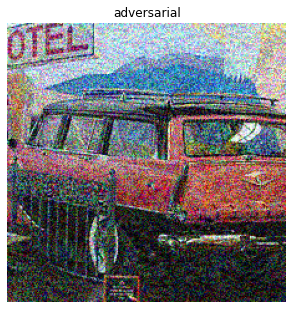

In [24]:
imshow(out[0], 'adversarial')

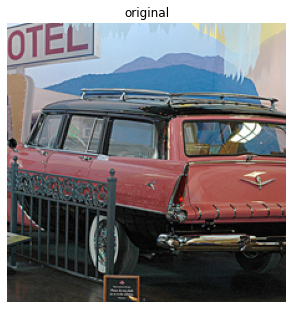

In [26]:
imshow(inp[0], 'original')

In [27]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=train_attack)

Test:  [ 0/10]  eta: 0:00:14  loss: 1.091493 (1.091493)  acc1: 50.000000 (50.000000)  adv_loss: 1.106042 (1.106042)  adv_acc1: 0.000000 (0.000000)  time: 1.487029  data: 0.270818  max mem: 1456
Test:  [ 9/10]  eta: 0:00:01  loss: 1.095770 (1.097160)  acc1: 50.000000 (50.666667)  adv_loss: 1.112605 (1.113430)  adv_acc1: 0.000000 (0.666667)  time: 1.315169  data: 0.228885  max mem: 1456
Test: Total time: 0:00:13 (1.315430 s / it)
* Acc@1 50.667 loss 1.097
* adv_Acc@1 0.667 adv_loss 1.113


In [25]:
import json
from pathlib import Path
import pandas as pd
import os
from tqdm import tqdm


import torch
from torch import nn

import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as pth_transforms

from dino import utils


def train(model, classifier, train_loader, validation_loader, log_dir=None, tensor_dir=None, optimizer=None, adversarial_attack=None, epochs=5, val_freq=1, batch_size=16,  lr=0.001, to_restore = {"epoch": 0, "best_acc": 0.}, n=4, avgpool_patchtokens=False):
    """ Trains a classifier ontop of a base model. The input can be perturbed by selecting an adversarial attack.
        
        :param model: base model (frozen)
        :param classifier: classifier to train
        :param train_loader: dataloader of the train dataset
        :param validation_loader: dataloader of the validation dataset
        :param log_dir: path to the log directory.
        :param tensor_dir: if set saves the output of the model in the dir
        :param optimizer: optimizer for the training process. Default: None -> uses the SGD as defined by DINO.
        :param adversarial_attack: adversarial attack for adversarial training. Default: None -> the classifier is trained without adversarial perturbation.
        :param epochs: number of epochs to train the classifier on. Default: 5
        :param val_freq: frequency (in epochs) in which the classifier is validated.
        :param batch_size: batch_size for training and validation. Default: 16
        :param lr: the learning rate of the optimizer if the DINO optimizer is used. Default: 0.001
        :param to_restore:
        :param n: from DINO. Default: 4
        :param avgpool_patchtokens: from DINO. Default: False
        
    """
    model.cuda()
    model.eval()
    
    if optimizer is None:
        optimizer = torch.optim.SGD(
            classifier.parameters(),
            lr * (batch_size * utils.get_world_size()) / 256., # linear scaling rule
            momentum=0.9,
            weight_decay=0, # we do not apply weight decay
        )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0)
    
    # Optionally resume from a checkpoint
    utils.restart_from_checkpoint(
        Path(log_dir, "checkpoint.pth.tar"),
        run_variables=to_restore,
        state_dict=classifier,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    start_epoch = to_restore["epoch"]
    best_acc = to_restore["best_acc"]
    
    # train loop
    loggers = {'train':[], 'validation':[]}
    for epoch in range(start_epoch, epochs):
        if 'set_epoch' in dir(train_loader.sampler):
            train_loader.sampler.set_epoch(epoch)

        # train epoch
        train_stats, metric_logger = train_epoch(model, classifier, optimizer, train_loader, tensor_dir, adversarial_attack, epoch, n, avgpool_patchtokens)
        loggers['train'].append(metric_logger)
        scheduler.step()

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     'epoch': epoch}
        
        # validate
        if epoch % val_freq == 0 or epoch == epochs - 1:
            test_stats, metric_logger = validate_network(model, classifier, validation_loader, tensor_dir, adversarial_attack, n, avgpool_patchtokens)
            loggers['validation'].append(metric_logger)
            print(f"Accuracy at epoch {epoch} of the network on the {len(validation_loader)} test images: {test_stats['acc1']:.1f}%")
            best_acc = max(best_acc, test_stats["acc1"])
            print(f'Max accuracy so far: {best_acc:.2f}%')
            log_stats = {**{k: v for k, v in log_stats.items()},
                         **{f'test_{k}': v for k, v in test_stats.items()}}
        # log
        if utils.is_main_process():
            with (Path(log_dir) / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")
            save_dict = {
                "epoch": epoch + 1,
                "state_dict": classifier.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "best_acc": best_acc,
            }
            torch.save(save_dict, Path(log_dir, "checkpoint.pth.tar"))
    print("Training of the supervised linear classifier on frozen features completed.\n"
                "Top-1 test accuracy: {acc:.1f}".format(acc=best_acc))
    return loggers
    
    


def train_epoch(model, classifier, optimizer, train_loader, tensor_dir=None, adversarial_attack=None, epoch=0, n=4, avgpool=False):
    """ Trains a classifier ontop of a base model. The input can be perturbed by selecting an adversarial attack.
        
        :param model: base model (frozen)
        :param classifier: classifier to train
        :param optimizer: optimizer for the training process.
        :param train_loader: dataloader of the train dataset
        :param tensor_dir: if set saves the output of the model in the dir

        :param adversarial_attack: adversarial attack for adversarial training. Default: None -> the classifier is trained without adversarial perturbation.
        :param epochs: The current epch
        :param n: from DINO. Default: 4
        :param avgpool_patchtokens: from DINO. Default: False
        
    """
    classifier.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    for (inp, target, names) in metric_logger.log_every(train_loader, 20, header):
        
        # move to gpu
        inp = inp.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # adversarial attack  
        if adversarial_attack is not None:
            inp = adversarial_attack(inp, target)
        
        # Normalize
        transform = pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        inp = transform(inp)
        
        # forward
        with torch.no_grad():
            if 'get_intermediate_layers' in dir(model):
                intermediate_output = model.get_intermediate_layers(inp, n)
                output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
                if avgpool:
                    output = torch.cat((output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
                    output = output.reshape(output.shape[0], -1)
            else:
                output = model(inp)

        # save output      
        if tensor_dir is not None and epoch == 0:
            save_output_batch(output, names, tensor_dir)
        
        output = classifier(output)

        # compute cross entropy loss
        loss = nn.CrossEntropyLoss()(output, target)

        # compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # step
        optimizer.step()

        # log 
        torch.cuda.synchronize()
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}, metric_logger


def validate_network(model, classifier, validation_loader, tensor_dir=None, adversarial_attack=None, n=4, avgpool=False):
    """ Validates a classifier
        
        :param model: base model (frozen)
        :param classifier: classifier to train
        :param validation_loader: dataloader of the validation dataset
        :param tensor_dir: if set saves the output of the model in the dir
        :param adversarial_attack: adversarial attack for adversarial training. Default: None -> the classifier is trained without adversarial perturbation.
        :param n: from DINO. Default: 4
        :param avgpool_patchtokens: from DINO. Default: False
        
    """
    model.eval()
    classifier.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    if 'num_labels' in dir(classifier):
        num_labels = classifier.num_labels
    else:
        num_labels = classifier.module.num_labels
    for inp, target, names in metric_logger.log_every(validation_loader, 20, header):

        # move to gpu
        inp = inp.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True) 

        # Normalize
        transform = pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        norminp = transform(inp)  
        
        # benign
        # forward
        with torch.no_grad():
            if 'get_intermediate_layers' in dir(model):
                intermediate_output = model.get_intermediate_layers(norminp, n)
                output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
                if avgpool:
                    output = torch.cat((output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
                    output = output.reshape(output.shape[0], -1)
            else:
                output = model(norminp)
                
            # save output
            if tensor_dir is not None:
                save_output_batch(output, names, tensor_dir)

            output = classifier(output)
            loss = nn.CrossEntropyLoss()(output, target)
        
        if num_labels >= 5:
            acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
        else:
            acc1, = utils.accuracy(output, target, topk=(1,))

        batch_size = inp.shape[0]
        metric_logger.update(loss=loss.item())
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        if num_labels >= 5:
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
        
        # adversarial attack
        if adversarial_attack is not None:
            inp = adversarial_attack(inp, target)

            # Normalize
            transform = pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            inp = transform(inp)  

            # forward
            with torch.no_grad():
                if 'get_intermediate_layers' in dir(model):
                    intermediate_output = model.get_intermediate_layers(inp, n)
                    output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
                    if avgpool:
                        output = torch.cat((output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
                        output = output.reshape(output.shape[0], -1)
                else:
                    output = model(inp)

                # save output
                if tensor_dir is not None:
                    save_output_batch(output, names, tensor_dir)

                output = classifier(output)
                adv_loss = nn.CrossEntropyLoss()(output, target)

            if num_labels >= 5:
                adv_acc1, adv_acc5 = utils.accuracy(output, target, topk=(1, 5))
            else:
                adv_acc1, = utils.accuracy(output, target, topk=(1,))

            batch_size = inp.shape[0]
            metric_logger.update(adv_loss=adv_loss.item())
            metric_logger.meters['adv_acc1'].update(adv_acc1.item(), n=batch_size)
            if num_labels >= 5:
                metric_logger.meters['adv_acc5'].update(adv_acc5.item(), n=batch_size)
                
    if num_labels >= 5:
        print('* Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f} loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5, losses=metric_logger.loss))
        if adversarial_attack is not None:
            print('* adv_Acc@1 {top1.global_avg:.3f} adv_Acc@5 {top5.global_avg:.3f} adv_loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.adv_acc1, top5=metric_logger.adv_acc5, losses=metric_logger.adv_loss))
    else:
        print('* Acc@1 {top1.global_avg:.3f} loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.acc1, losses=metric_logger.loss))
        if adversarial_attack is not None:
            print('* adv_Acc@1 {top1.global_avg:.3f} adv_loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.adv_acc1, losses=metric_logger.adv_loss))
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}, metric_logger



def save_output_batch(batch_out, batch_names, output_dir):
    for out, name in zip(batch_out, batch_names):
        torch.save(out, Path(output_dir,name.split('.')[0]+'.pt'))